In [1]:
import pandas as pd
import numpy as np
import main as sigmod
import similar_feature_grouping as similar_feature_grouping
import helper as helper

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gunesyurdakul/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
dataset_path="../datasets/2013_camera_specs/"

In [2]:
dataset_df = sigmod.create_brand_dataframe(dataset_path)
dataset_df = sigmod.compute_brand_blocking(dataset_df)
#pairs_df = sigmod.get_block_pairs_df(dataset_df)

NameError: name 'sigmod' is not defined

### GROUPING SAME PRODUCTS FROM LABELLED SET

In [ ]:
labelled_df = pd.read_csv('../datasets/sigmod_large_labelled_dataset.csv')

In [ ]:
same_products = sigmod.grouping_same_products_from_labelled_set(labelled_df)

In [ ]:
#They all represent the same products
len(labelled_df)

### GET ALL KEYS and values

In [ ]:
data_dict=sigmod.get_all_keys_values(dataset_path)
dataset_df['all_features'] = dataset_df['spec_id'].apply(lambda x: data_dict[x])

In [ ]:
dataset_df.to_pickle('dataset_df.pickle')

In [ ]:
a = pd.read_pickle('dataset_df.pickle')

In [ ]:
dataset_df

In [12]:
from gensim.models import Word2Vec

In [13]:
emb_dim=200
model = Word2Vec(all_text, size=emb_dim, window=5, min_count=1, workers=4)
model.train(all_text,total_examples=model.corpus_count,epochs=model.epochs)

(35264665, 36348795)

In [14]:
model.most_similar('supply ability')

/Users/gunesyurdakul/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':


[('\x7foriginal sj4000', 0.9773316383361816),
 ('20000pcs/week camera', 0.9656436443328857),
 ('120000 piece/pieces', 0.9626075029373169),
 ('30,000 piece/pieces per', 0.9593505859375),
 ('300,000pcs pc', 0.9568647742271423),
 ('2200 piece/pieces', 0.9554373025894165),
 ('80000 pair/pairs', 0.9548500776290894),
 ('5,000 unit/units', 0.9547521471977234),
 ('10,000 set/sets', 0.9536374807357788),
 ('1000000 set/sets', 0.9535791277885437)]

In [14]:
all_features={}
for features in data_dict.values():
    for feature in features.keys():
        if feature not in all_features.keys():
            all_features[feature]=0            
        all_features[feature]+=1

In [15]:
all_features_filtered=[feature for feature,count in all_features.items() if count>200]

In [16]:
len(all_features_filtered)

364

In [17]:
model.save('word2vec_200_features')

In [18]:
model= Word2Vec.load('word2vec_200_features')
words = all_features_filtered
wvs = model.wv[words]

# FOR A SINGLE BLOCK - Nikon

In [19]:
dataset_df.head(50)
dataset_df = dataset_df.explode('blocking_key')
grouped_df = dataset_df.groupby(['blocking_key'])

In [20]:
dataset_df = dataset_df.set_index('spec_id')

In [21]:
blocking_key="nikon"
block_df = grouped_df.get_group(blocking_key)

In [22]:
len(set(dataset_df['blocking_key']))

102

In [23]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
block_df

,source,spec_number,spec_id,page_title,brand,blocking_key,all_features
155,www.price-hunt.com,9551,www.price-hunt.com//9551,nikon performance p330 point & shoot camera be...,Nikon,nikon,"{'battery type': 'li-ion battery', '<page titl..."
196,www.price-hunt.com,732,www.price-hunt.com//732,nikon d610 dslr camera best price in india 201...,Nikon,nikon,"{'external flash': 'external flash', '<page ti..."
217,www.price-hunt.com,786,www.price-hunt.com//786,nikon d600 dslr camera best price in india 201...,Nikon,nikon,{'<page title>': 'nikon d600 dslr camera best ...
239,www.price-hunt.com,871,www.price-hunt.com//871,nikon 1 j1 mirrorless camera best price in ind...,Nikon,nikon,{'<page title>': 'nikon 1 j1 mirrorless camera...
246,www.price-hunt.com,830,www.price-hunt.com//830,nikon d7100 dslr camera best price in india 20...,Nikon,nikon,{'<page title>': 'nikon d7100 dslr camera best...
...,...,...,...,...,...,...,...
29497,www.buzzillions.com,2893,www.buzzillions.com//2893,nikon d600 | nikon d600 digital slr camera (bo...,,nikon,"{'compatible with macintosh': 'yes', '<page ti..."
29525,www.buzzillions.com,2538,www.buzzillions.com//2538,nikon d5200 | nikon d5200 digital slr camera w...,,nikon,"{'compatible with macintosh': 'yes', '<page ti..."
29576,www.buzzillions.com,1820,www.buzzillions.com//1820,manual feature in d3100 shots | nikon d3100 di...,,nikon,{'<page title>': 'manual feature d3100 shots |...
29585,www.buzzillions.com,1932,www.buzzillions.com//1932,nikon | nikon d7100 digital slr camera (body o...,,nikon,{'<page title>': 'nikon | nikon d7100 digital ...


## CLUSTERING INSIDE BLOCK

In [25]:
import re
from nltk import everygrams

block_df['concat_wordvector']=''
for index, row in block_df.iterrows():
    x=row['page_title']
    block_df.at[index,'concat_wordvector']=sigmod.get_avg_vector(\
        ' '.join([' '.join(x[idx:].split()[:3]) for idx in [x.start() for x in re.finditer(blocking_key, x)]] + [' '.join(sigmod.extract_model_words(token)) for token in list(everygrams(x.split(),2,3))]),blocking_key)                                                                                                                                                     

/Users/gunesyurdakul/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NameError: name 'model' is not defined

In [39]:
X=np.zeros((len(block_df),400))
for i in range(len(block_df)):
    X[i]=block_df['concat_wordvector'][i]

In [40]:
# visualize embeddings
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, n_iter=1000, perplexity=20)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(X)
labels = block_df['spec_number'].values

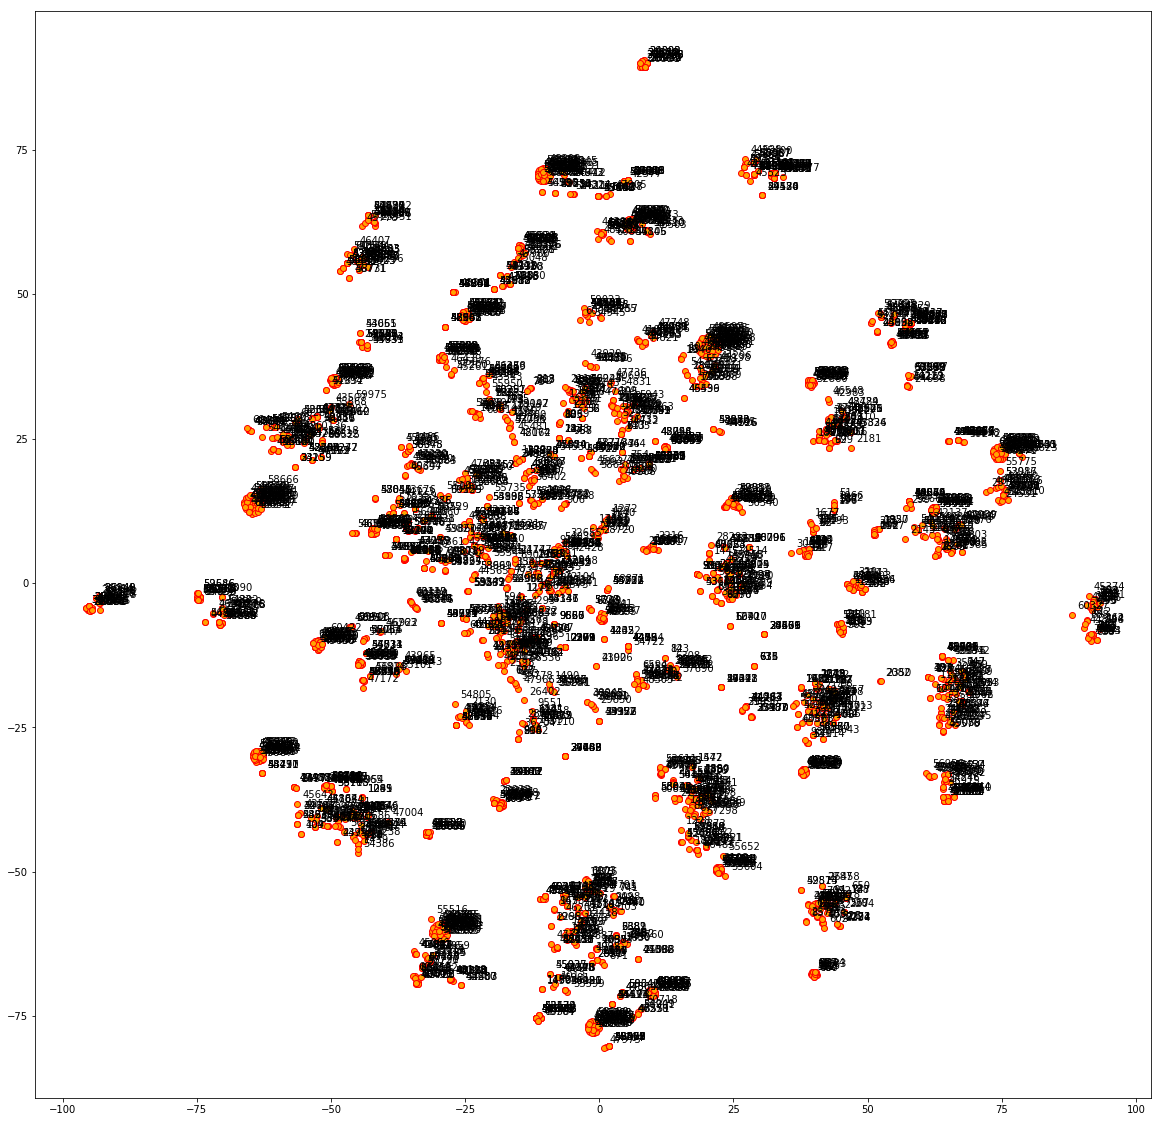

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [42]:
plt.show()

In [43]:
T.shape

(2856, 2)

#### KMeans

In [44]:
from nltk.cluster import KMeansClusterer
import nltk
%matplotlib inline

In [45]:
from sklearn.cluster import KMeans
import numpy as np
kclusterer = KMeans(n_clusters=5, random_state=0).fit(T)
assigned_clusters = kclusterer.labels_

In [46]:
from sklearn.cluster import DBSCAN
import numpy as np
kclusterer = DBSCAN(eps=0.5, min_samples=1).fit(T)
assigned_clusters = kclusterer.labels_

In [47]:
len(set(assigned_clusters))

1045

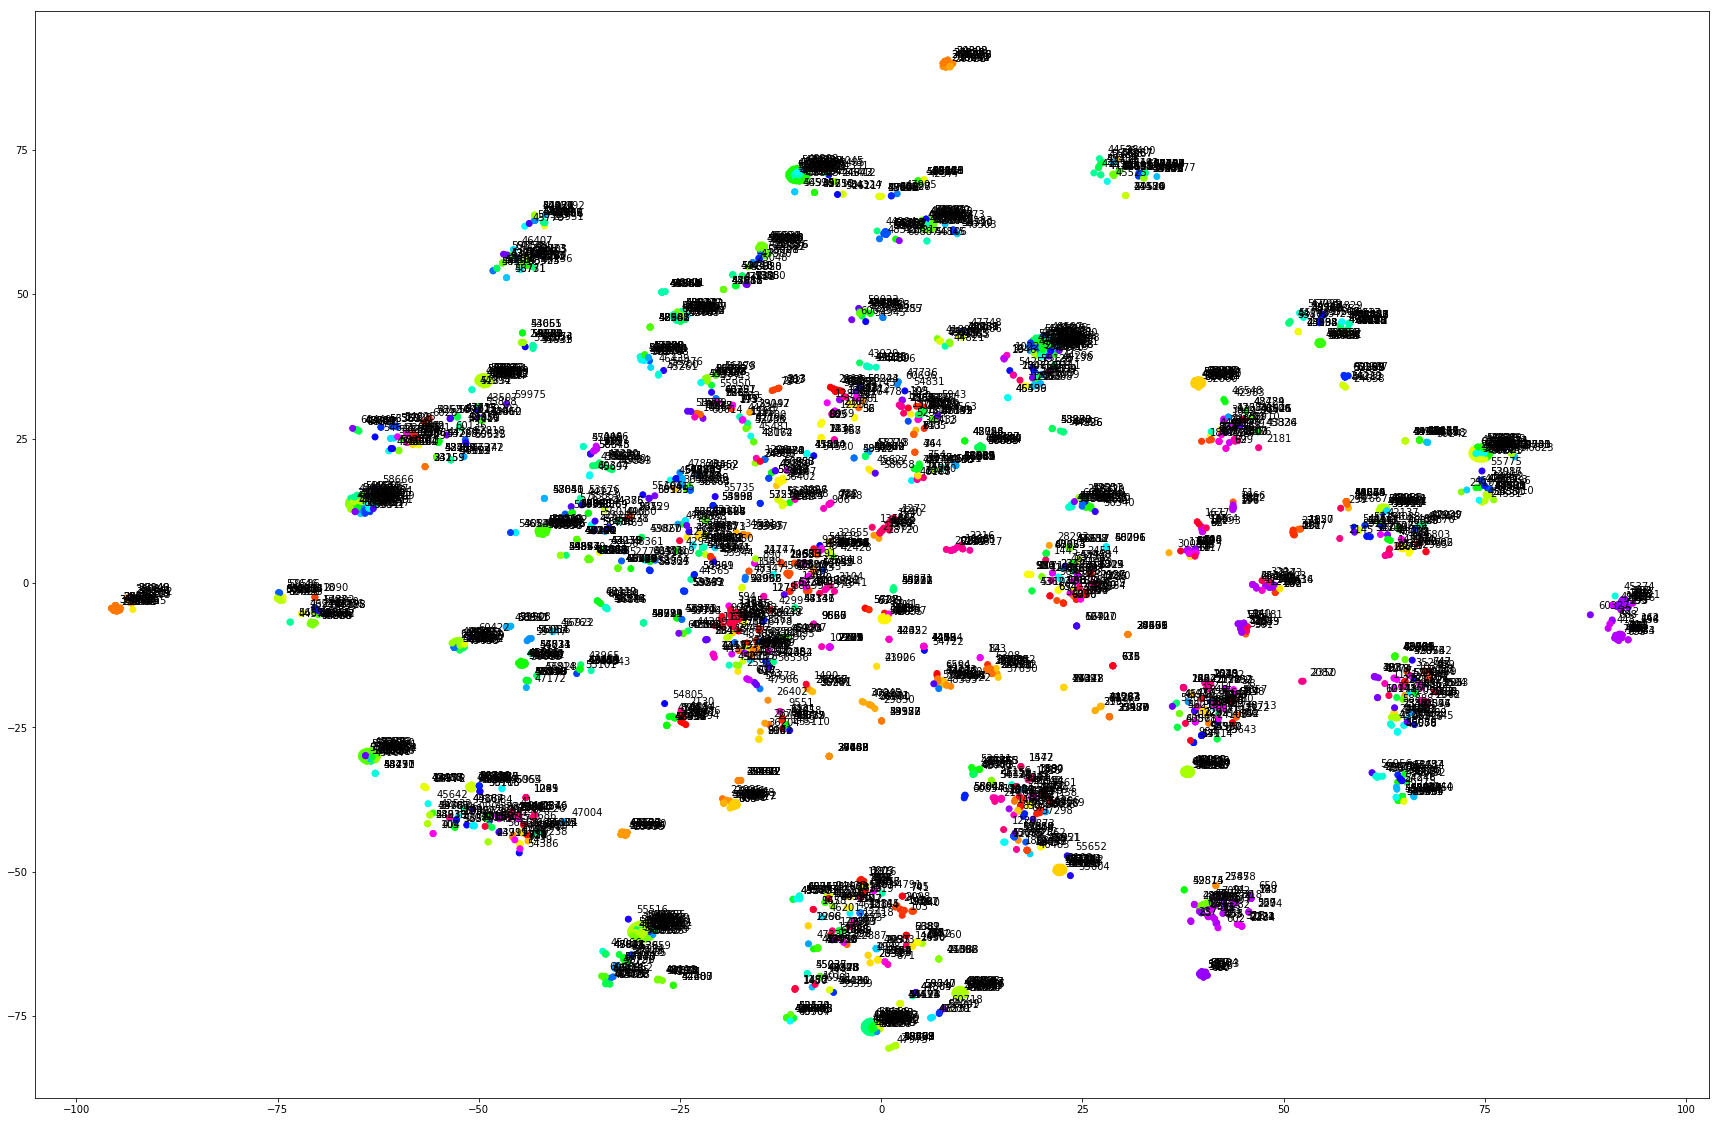

In [48]:
plt.figure(figsize=(30,20))
plt.scatter(T[:,0], T[:,1], c=assigned_clusters, cmap='hsv')

for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [49]:
block_df['inblock_cluster'] = assigned_clusters

/Users/gunesyurdakul/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [50]:
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 3000
block_group_df = block_df.groupby('inblock_cluster')

In [51]:
for i in range(len(list(set(assigned_clusters)))):
    if(len(block_group_df.get_group(i)[['page_title']])>1):
        print(block_group_df.get_group(i)[['page_title']].values)
        print('-------------------')
        

[['nikon d5300 black slr digital camera kit w/ 18-140 mm vr lens (24.2 mp, sd/sdhc/sdxc card slot) price comparison at buy.net']
 ['nikon d5300 dslr camera red import 18 55vr w a tele 7 lens 24gb bundle 018208015207 | ebay']
 ['nikon d5300 black w af s nikkor 70 200mm f4g ed vr 350 clicks 018208015191 | ebay']
 ['nikon d5300 kit 18-140mm digital camera prices, shopping comparison for nikon d 5300 kit 18 140mm, buy online in india - shopmania']]
-------------------
[['nikon d3300 black slr digital camera kit w/ 18-55 mm lens (24.2 mp, sd/sdhc/sdxc card slot) price comparison at buy.net']
 ['nikon d3300 red slr digital camera kit w/ 18-55 mm lens (24.2 mp, sd/sdhc/sdxc card slot) price comparison at buy.net']
 ['nikon d3300 gray slr digital camera kit w/ 18-55 mm lens (24.2 mp, sd/sdhc/sdxc card slot) price comparison at buy.net']
 ['nikon d3300 with af-s 18-55 mm vr kit lens ii + af-s 55-200 mm vr kit dslr camera rs.37358 price in india - buy nikon d3300 with af-s 18-55 mm vr kit lens i

-------------------
[['cammarkt | nikon d40x 10.2mp digital slr camera (body only)']
 ['cammarkt | nikon d40x 10.2mp digital slr camera with 18-135mm f/3.5-5.6g ed']
 ['nikon d40x 10.2mp digital slr camera on sale for $999.95']
 ['nikon d40x 10.2mp digital slr camera on sale for $850.99']]
-------------------
[['cammarkt | nikon d80 10.2mp digital slr camera kit with 18-55mm ed ii af-s']
 ['cammarkt | nikon d3000 10mp digital slr camera with 18-55mm f/3.5-5.6g & 55']]
-------------------
[['cammarkt | nikon d750 fx-format digital slr camera w/ 24-120mm f/4g ed vr a']
 ['nikon d750 dslr camera body s5127 | ebay']
 ['nikon d750 fx-format digital slr camera on sale for $1999.99']]
-------------------
[['cammarkt | nikon 1 j2 10.1 mp hd digital camera with 10-30mm and 30-110mm v']
 ['nikon 1 v1 mirrorless 10.1 megapixels digital camera with nikkor 10-30mm vr zoom lens, cmos cx sensor, 3.0" display, usb, black reviews | buzzillions.com']]
-------------------
[['cammarkt | nikon d40 6.1mp di

-------------------
[['buy discount nikon df dslr from cambuy camera store in sydney']
 ['buy discount nikon df dslr from cambuy camera store in sydney']
 ['buy discount nikon df dslr from cambuy camera store in sydney']
 ['buy discount nikon df dslr from cambuy camera store in sydney']
 ['nikon df silver near n from japan 2247 018208015269 | ebay']
 ['sale brand new nikon df silver dslr full frame camera body only express ship 018208015269 | ebay']
 ['nikon df 16 2 mp digital slr camera black body only latest model | ebay']
 ['nikon df body only digital slr camera- silver']
 ['nikon df body only digital slr camera - black']
 ['nikon df dslr  body only (black)']
 ['nikon df dslr  body only (silver)']
 ['nikon df dslr  new zealand prices - priceme']
 ['nikon df - price comparison & reviews - digital cameras - australia']]
-------------------
[['buy nikon d5300 single lens kit with 18-55mm vr ii lens in black from cambuy']
 ['nikon d5300 single lens kit with 18-55mm vr ii lens - grey - c

-------------------
[['nikon d200 body 10 2 megapixel digital slr camera 23865 018208252350 | ebay']
 ['nikon d200 body 10 2 mp digital slr camera black "excellent " 018208252350 | ebay']]
-------------------
[['nikon d7000 16 2 mp digital slr camera black body only 25468 018208254682 | ebay']
 ['nikon d7000 16 2 mp digital slr camera black body only mint condition 018208254682 | ebay']
 ['nikon d7000 16 2 mp digital slr 64 mb lexar professional card 018208254682 | ebay']
 ['nikon d7000 16 2 mp digital slr camera black body only 8558 018208254682 | ebay']
 ['nikon d7000 16 2 mp digital slr camera wireless remote 1 238 shutter count 018208254682 | ebay']
 ['nikon d7000 16 2 megapixel dx digital slr body great camera 24090 018208254682 | ebay']
 ['nikon d7000 16 2 mp digital slr camera body only shutter count 9980 extras 018208254682 | ebay']
 ['nikon d7000 16 2 megapixel dx digital slr body great camera 018208254682 | ebay']
 ['nikon d7000 16 2 megapixel dx digital slr body read descrip

-------------------
[['nikon d60 digital slr camera bundle with 2 lenses charger and case 10 2 mp | ebay']
 ['nikon d60 digital single lens reflex camera black body only and accessories | ebay']
 ['lot of three nikon d60 digital bodies not functional for parts or repair | ebay']]
-------------------
[['nikon d90 camera body with everything shown in gallery pictures 018208254460 | ebay']
 ['nikon d90 camera body with everything shown in pictures 018208254460 | ebay']
 ['nikon d90 camera and accessories 018208254460 | ebay']]
-------------------
[['nikon d80 10 2 mp digital slr camera package 18208094837 | ebay']
 ['nikon d80 10 2 mp digital slr camera body only faulty damaged parts or repair 018208254125 | ebay']
 ['nikon d80 10 2 mp digital slr camera body only 018208254125 | ebay']]
-------------------
[['nikon d5000 12 3mp digital slr camera body with accessories shown | ebay']
 ['nikon d5000 12 3mp digital slr camera w 55 200mm lens kit | ebay']]
-------------------
[['nikon d5100 1

*****

In [44]:
labelled_df = pd.read_csv('../datasets/sigmod_large_labelled_dataset.csv')

In [45]:
labelled_index = list(set(list(labelled_df.left_spec_id.values)+list(labelled_df.right_spec_id.values)))

In [48]:
labelled_data_df = dataset_df.loc[labelled_index]

In [52]:
labelled_grouped_df = labelled_data_df.groupby(['blocking_key'])

0.9242005813953489 0.29897731280122253 0.4517985611510792
0.9242005813953489 0.29897731280122253 0.4517985611510792
2 2 0.0 0.4517985611510792
-------
0.9519621109607578 0.2977077700717057 0.4535702132994252
0.9519621109607578 0.2977077700717057 0.4535702132994252
2 2 0.2 0.4535702132994252
-------
0.9838769458858414 0.24962971670389092 0.3982222888968065
0.9838769458858414 0.24962971670389092 0.3982222888968065
2 2 0.4 0.3982222888968065
-------
0.9948879276445144 0.17844128364875986 0.302607447571964
0.9948879276445144 0.17844128364875986 0.302607447571964
2 2 0.6000000000000001 0.302607447571964
-------
0.9994827586206897 0.1362877630186905 0.23986759077273198
0.9994827586206897 0.1362877630186905 0.23986759077273198
2 2 0.8 0.23986759077273198
-------
0.9228816018572258 0.299071353003409 0.4517480779133153
0.9228816018572258 0.299071353003409 0.4517480779133153
2 3 0.0 0.4517480779133153
-------
0.9519765519314595 0.2978018102738921 0.45368098708834004
0.9519765519314595 0.2978018102738921 0.45368098708834004
2 3 0.2 0.45368098708834004
-------
0.9838769458858414 0.24962971670389092 0.3982222888968065
0.9838769458858414 0.24962971670389092 0.3982222888968065
2 3 0.4 0.3982222888968065
-------
0.9948879276445144 0.17844128364875986 0.302607447571964
0.9948879276445144 0.17844128364875986 0.302607447571964
2 3 0.6000000000000001 0.302607447571964
-------
0.9994827586206897 0.1362877630186905 0.23986759077273198
0.9994827586206897 0.1362877630186905 0.23986759077273198
2 3 0.8 0.23986759077273198
-------
0.91070157962146 0.3009051369460444 0.45234939652582656
0.91070157962146 0.3009051369460444 0.45234939652582656
2 4 0.0 0.45234939652582656
-------
0.9468796433878157 0.2996355942165276 0.4552192160014287
0.9468796433878157 0.2996355942165276 0.4552192160014287
2 4 0.2 0.4552192160014287
-------
0.9826456198652266 0.25026448806864937 0.3989281966721631
0.9826456198652266 0.25026448806864937 0.3989281966721631
2 4 0.4 0.3989281966721631
-------
0.9948879276445144 0.17844128364875986 0.302607447571964
0.9948879276445144 0.17844128364875986 0.302607447571964
2 4 0.6000000000000001 0.302607447571964
-------
0.9994827586206897 0.1362877630186905 0.23986759077273198
0.9994827586206897 0.1362877630186905 0.23986759077273198
2 4 0.8 0.23986759077273198
-------
0.9145585602130297 0.46832020688844483 0.6194415075564401
0.9145585602130297 0.46832020688844483 0.6194415075564401
3 2 0.0 0.6194415075564401
-------
0.9385162360748993 0.46545198072175853 0.6222850856514223
0.9385162360748993 0.46545198072175853 0.6222850856514223
3 2 0.2 0.6222850856514223
-------
0.9573913570519426 0.3713647584342306 0.5351492360334723
0.9573913570519426 0.3713647584342306 0.5351492360334723
3 2 0.4 0.5351492360334723
-------
0.9684545937334041 0.2143646408839779 0.3510298363811357
0.9684545937334041 0.2143646408839779 0.3510298363811357
3 2 0.6000000000000001 0.3510298363811357
-------
0.9995106834121676 0.14406958974961795 0.2518390662885792
0.9995106834121676 0.14406958974961795 0.2518390662885792
3 2 0.8 0.2518390662885792
-------
0.9145585602130297 0.46832020688844483 0.6194415075564401
0.9145585602130297 0.46832020688844483 0.6194415075564401
3 3 0.0 0.6194415075564401
-------
0.9385162360748993 0.46545198072175853 0.6222850856514223
0.9385162360748993 0.46545198072175853 0.6222850856514223
3 3 0.2 0.6222850856514223
-------
0.9573913570519426 0.3713647584342306 0.5351492360334723
0.9573913570519426 0.3713647584342306 0.5351492360334723
3 3 0.4 0.5351492360334723
-------
0.9684545937334041 0.2143646408839779 0.3510298363811357
0.9684545937334041 0.2143646408839779 0.3510298363811357
3 3 0.6000000000000001 0.3510298363811357
-------
0.9995106834121676 0.14406958974961795 0.2518390662885792
0.9995106834121676 0.14406958974961795 0.2518390662885792
3 3 0.8 0.2518390662885792
-------
0.9145585602130297 0.46832020688844483 0.6194415075564401
0.9145585602130297 0.46832020688844483 0.6194415075564401
3 4 0.0 0.6194415075564401
-------
0.9385162360748993 0.46545198072175853 0.6222850856514223
0.9385162360748993 0.46545198072175853 0.6222850856514223
3 4 0.2 0.6222850856514223
-------
0.9573913570519426 0.3713647584342306 0.5351492360334723
0.9573913570519426 0.3713647584342306 0.5351492360334723
3 4 0.4 0.5351492360334723
-------
0.9684545937334041 0.2143646408839779 0.3510298363811357
0.9684545937334041 0.2143646408839779 0.3510298363811357
3 4 0.6000000000000001 0.3510298363811357
-------
0.9995106834121676 0.14406958974961795 0.2518390662885792
0.9995106834121676 0.14406958974961795 0.2518390662885792
3 4 0.8 0.2518390662885792
-------
0.8869807000327118 0.5099800164570354 0.6476093803645266
0.8869807000327118 0.5099800164570354 0.6476093803645266
4 2 0.0 0.6476093803645266
-------
0.9175709604664029 0.5069237098859762 0.6530575158251809
0.9175709604664029 0.5069237098859762 0.6530575158251809
4 2 0.2 0.6530575158251809
-------
0.9445426425099426 0.4020218643470084 0.5639934695493
0.9445426425099426 0.4020218643470084 0.5639934695493
4 2 0.4 0.5639934695493
-------
0.969493898779756 0.2278829199482779 0.36902518416995034
0.969493898779756 0.2278829199482779 0.36902518416995034
4 2 0.6000000000000001 0.36902518416995034
-------
0.9995120364346128 0.1444692606089103 0.25244952036645235
0.9995120364346128 0.1444692606089103 0.25244952036645235
4 2 0.8 0.25244952036645235
-------
0.8869807000327118 0.5099800164570354 0.6476093803645266
0.8869807000327118 0.5099800164570354 0.6476093803645266
4 3 0.0 0.6476093803645266
-------
0.9175709604664029 0.5069237098859762 0.6530575158251809
0.9175709604664029 0.5069237098859762 0.6530575158251809
4 3 0.2 0.6530575158251809
-------
0.9445426425099426 0.4020218643470084 0.5639934695493
0.9445426425099426 0.4020218643470084 0.5639934695493
4 3 0.4 0.5639934695493
-------
0.969493898779756 0.2278829199482779 0.36902518416995034
0.969493898779756 0.2278829199482779 0.36902518416995034
4 3 0.6000000000000001 0.36902518416995034
-------
0.9995120364346128 0.1444692606089103 0.25244952036645235
0.9995120364346128 0.1444692606089103 0.25244952036645235
4 3 0.8 0.25244952036645235
-------
0.8869807000327118 0.5099800164570354 0.6476093803645266
0.8869807000327118 0.5099800164570354 0.6476093803645266
4 4 0.0 0.6476093803645266
-------
0.9175709604664029 0.5069237098859762 0.6530575158251809
0.9175709604664029 0.5069237098859762 0.6530575158251809
4 4 0.2 0.6530575158251809
-------
0.9445426425099426 0.4020218643470084 0.5639934695493
0.9445426425099426 0.4020218643470084 0.5639934695493
4 4 0.4 0.5639934695493
-------
0.969493898779756 0.2278829199482779 0.36902518416995034
0.969493898779756 0.2278829199482779 0.36902518416995034
4 4 0.6000000000000001 0.36902518416995034
-------
0.9995120364346128 0.1444692606089103 0.25244952036645235
0.9995120364346128 0.1444692606089103 0.25244952036645235
4 4 0.8 0.25244952036645235
-------
0.8875080581620228 0.5826025625955096 0.7034361383538896
0.8875080581620228 0.5826025625955096 0.7034361383538896
5 2 0.0 0.7034361383538896
-------
0.9183741897027047 0.5795462560244504 0.7106389725701602
0.9183741897027047 0.5795462560244504 0.7106389725701602
5 2 0.2 0.7106389725701602
-------
0.9520809469263077 0.46897848830374983 0.6284121158662404
0.9520809469263077 0.46897848830374983 0.6284121158662404
5 2 0.4 0.6284121158662404
-------
0.9740866610025488 0.2695427295168685 0.4222447288463309
0.9740866610025488 0.2695427295168685 0.4222447288463309
5 2 0.6000000000000001 0.4222447288463309
-------
0.9995168304074731 0.14590337369225345 0.25463646807812246
0.9995168304074731 0.14590337369225345 0.25463646807812246
5 2 0.8 0.25463646807812246
-------
0.8875080581620228 0.5826025625955096 0.7034361383538896
0.8875080581620228 0.5826025625955096 0.7034361383538896
5 3 0.0 0.7034361383538896
-------
0.9183741897027047 0.5795462560244504 0.7106389725701602
0.9183741897027047 0.5795462560244504 0.7106389725701602
5 3 0.2 0.7106389725701602
-------
0.9520809469263077 0.46897848830374983 0.6284121158662404
0.9520809469263077 0.46897848830374983 0.6284121158662404
5 3 0.4 0.6284121158662404
-------
0.9740866610025488 0.2695427295168685 0.4222447288463309
0.9740866610025488 0.2695427295168685 0.4222447288463309
5 3 0.6000000000000001 0.4222447288463309
-------
0.9995168304074731 0.14590337369225345 0.25463646807812246
0.9995168304074731 0.14590337369225345 0.25463646807812246
5 3 0.8 0.25463646807812246
-------
0.8875080581620228 0.5826025625955096 0.7034361383538896
0.8875080581620228 0.5826025625955096 0.7034361383538896
5 4 0.0 0.7034361383538896
-------
0.9183741897027047 0.5795462560244504 0.7106389725701602
0.9183741897027047 0.5795462560244504 0.7106389725701602
5 4 0.2 0.7106389725701602
-------
0.9520809469263077 0.46897848830374983 0.6284121158662404
0.9520809469263077 0.46897848830374983 0.6284121158662404
5 4 0.4 0.6284121158662404
-------
0.9740866610025488 0.2695427295168685 0.4222447288463309
0.9740866610025488 0.2695427295168685 0.4222447288463309
5 4 0.6000000000000001 0.4222447288463309
-------
0.9995168304074731 0.14590337369225345 0.25463646807812246
0.9995168304074731 0.14590337369225345 0.25463646807812246
5 4 0.8 0.25463646807812246
-------
0.7707505614095699 0.8391912542611967 0.8035161569889812
0.7707505614095699 0.8391912542611967 0.8035161569889812
6 2 0.0 0.8035161569889812
-------
0.8242698191933241 0.8359938873868579 0.8300904581266414
0.8242698191933241 0.8359938873868579 0.8300904581266414
6 2 0.2 0.8300904581266414
-------
0.9579619197033445 0.6316445280357352 0.76130970091101
0.9579619197033445 0.6316445280357352 0.76130970091101
6 2 0.4 0.76130970091101
-------
0.9786828304842334 0.33783942635476666 0.5022894893215422
0.9786828304842334 0.33783942635476666 0.5022894893215422
6 2 0.6000000000000001 0.5022894893215422
-------
0.9995239606474136 0.14808980839308805 0.25796015316256116
0.9995239606474136 0.14808980839308805 0.25796015316256116
6 2 0.8 0.25796015316256116
-------
0.7707505614095699 0.8391912542611967 0.8035161569889812
0.7707505614095699 0.8391912542611967 0.8035161569889812
6 3 0.0 0.8035161569889812
-------
0.8242698191933241 0.8359938873868579 0.8300904581266414
0.8242698191933241 0.8359938873868579 0.8300904581266414
6 3 0.2 0.8300904581266414
-------
0.9579619197033445 0.6316445280357352 0.76130970091101
0.9579619197033445 0.6316445280357352 0.76130970091101
6 3 0.4 0.76130970091101
-------
0.9786828304842334 0.33783942635476666 0.5022894893215422
0.9786828304842334 0.33783942635476666 0.5022894893215422
6 3 0.6000000000000001 0.5022894893215422
-------
0.9995239606474136 0.14808980839308805 0.25796015316256116
0.9995239606474136 0.14808980839308805 0.25796015316256116
6 3 0.8 0.25796015316256116
-------
0.7707505614095699 0.8391912542611967 0.8035161569889812
0.7707505614095699 0.8391912542611967 0.8035161569889812
6 4 0.0 0.8035161569889812
-------
0.8242698191933241 0.8359938873868579 0.8300904581266414
0.8242698191933241 0.8359938873868579 0.8300904581266414
6 4 0.2 0.8300904581266414
-------
0.9579619197033445 0.6316445280357352 0.76130970091101
0.9579619197033445 0.6316445280357352 0.76130970091101
6 4 0.4 0.76130970091101
-------
0.9786828304842334 0.33783942635476666 0.5022894893215422
0.9786828304842334 0.33783942635476666 0.5022894893215422
6 4 0.6000000000000001 0.5022894893215422
-------
0.9995239606474136 0.14808980839308805 0.25796015316256116
0.9995239606474136 0.14808980839308805 0.25796015316256116
6 4 0.8 0.25796015316256116
-------
0.7707505614095699 0.8391912542611967 0.8035161569889812
0.7707505614095699 0.8391912542611967 0.8035161569889812
7 2 0.0 0.8035161569889812
-------
0.8242698191933241 0.8359938873868579 0.8300904581266414
0.8242698191933241 0.8359938873868579 0.8300904581266414
7 2 0.2 0.8300904581266414
-------
0.9579619197033445 0.6316445280357352 0.76130970091101
0.9579619197033445 0.6316445280357352 0.76130970091101
7 2 0.4 0.76130970091101
-------
0.9786828304842334 0.33783942635476666 0.5022894893215422
0.9786828304842334 0.33783942635476666 0.5022894893215422
7 2 0.6000000000000001 0.5022894893215422
-------
0.9995239606474136 0.14808980839308805 0.25796015316256116
0.9995239606474136 0.14808980839308805 0.25796015316256116
7 2 0.8 0.25796015316256116
-------
0.7707505614095699 0.8391912542611967 0.8035161569889812
0.7707505614095699 0.8391912542611967 0.8035161569889812
7 3 0.0 0.8035161569889812
-------
0.8242698191933241 0.8359938873868579 0.8300904581266414
0.8242698191933241 0.8359938873868579 0.8300904581266414
7 3 0.2 0.8300904581266414
-------
0.9579619197033445 0.6316445280357352 0.76130970091101
0.9579619197033445 0.6316445280357352 0.76130970091101
7 3 0.4 0.76130970091101
-------
0.9786828304842334 0.33783942635476666 0.5022894893215422
0.9786828304842334 0.33783942635476666 0.5022894893215422
7 3 0.6000000000000001 0.5022894893215422
-------
0.9995239606474136 0.14808980839308805 0.25796015316256116
0.9995239606474136 0.14808980839308805 0.25796015316256116
7 3 0.8 0.25796015316256116
-------
0.7707505614095699 0.8391912542611967 0.8035161569889812
0.7707505614095699 0.8391912542611967 0.8035161569889812
7 4 0.0 0.8035161569889812
-------
0.8242698191933241 0.8359938873868579 0.8300904581266414
0.8242698191933241 0.8359938873868579 0.8300904581266414
7 4 0.2 0.8300904581266414
-------
0.9579619197033445 0.6316445280357352 0.76130970091101
0.9579619197033445 0.6316445280357352 0.76130970091101
7 4 0.4 0.76130970091101
-------
0.9786828304842334 0.33783942635476666 0.5022894893215422
0.9786828304842334 0.33783942635476666 0.5022894893215422
7 4 0.6000000000000001 0.5022894893215422
-------
0.9995239606474136 0.14808980839308805 0.25796015316256116
0.9995239606474136 0.14808980839308805 0.25796015316256116
7 4 0.8 0.25796015316256116
-------
0.7738518090203205 0.8809921241330669 0.8239536494464538
0.7738518090203205 0.8809921241330669 0.8239536494464538
8 2 0.0 0.8239536494464538
-------
0.8250906037302219 0.8777947572587281 0.8506270860150137
0.8250906037302219 0.8777947572587281 0.8506270860150137
8 2 0.2 0.8506270860150137
-------
0.9602259355142386 0.6714470436111437 0.7902819668502172
0.9602259355142386 0.6714470436111437 0.7902819668502172
8 2 0.4 0.7902819668502172
-------
0.9804875007792532 0.36976607499706127 0.5370117454247473
0.9804875007792532 0.36976607499706127 0.5370117454247473
8 2 0.6000000000000001 0.5370117454247473
-------
0.9995239606474136 0.14808980839308805 0.25796015316256116
0.9995239606474136 0.14808980839308805 0.25796015316256116
8 2 0.8 0.25796015316256116
-------
0.7738518090203205 0.8809921241330669 0.8239536494464538
0.7738518090203205 0.8809921241330669 0.8239536494464538
8 3 0.0 0.8239536494464538
-------
0.8250906037302219 0.8777947572587281 0.8506270860150137
0.8250906037302219 0.8777947572587281 0.8506270860150137
8 3 0.2 0.8506270860150137
-------
0.9602259355142386 0.6714470436111437 0.7902819668502172
0.9602259355142386 0.6714470436111437 0.7902819668502172
8 3 0.4 0.7902819668502172
-------
0.9804875007792532 0.36976607499706127 0.5370117454247473
0.9804875007792532 0.36976607499706127 0.5370117454247473
8 3 0.6000000000000001 0.5370117454247473
-------
0.9995239606474136 0.14808980839308805 0.25796015316256116
0.9995239606474136 0.14808980839308805 0.25796015316256116
8 3 0.8 0.25796015316256116
-------
0.7738518090203205 0.8809921241330669 0.8239536494464538
0.7738518090203205 0.8809921241330669 0.8239536494464538
8 4 0.0 0.8239536494464538
-------
0.8250906037302219 0.8777947572587281 0.8506270860150137
0.8250906037302219 0.8777947572587281 0.8506270860150137
8 4 0.2 0.8506270860150137
-------
0.9602259355142386 0.6714470436111437 0.7902819668502172
0.9602259355142386 0.6714470436111437 0.7902819668502172
8 4 0.4 0.7902819668502172
-------
0.9804875007792532 0.36976607499706127 0.5370117454247473
0.9804875007792532 0.36976607499706127 0.5370117454247473
8 4 0.6000000000000001 0.5370117454247473
-------
0.9995239606474136 0.14808980839308805 0.25796015316256116
0.9995239606474136 0.14808980839308805 0.25796015316256116
8 4 0.8 0.25796015316256116
-------
0.6146809567293059 0.9020571294228282 0.7311444795914479
0.6146809567293059 0.9020571294228282 0.7311444795914479
9 2 0.0 0.7311444795914479
-------
0.6709191731302425 0.8988597625484894 0.7683403502778308
0.6709191731302425 0.8988597625484894 0.7683403502778308
9 2 0.2 0.7683403502778308
-------
0.8815990417727204 0.692159398142706 0.7754774134070854
0.8815990417727204 0.692159398142706 0.7754774134070854
9 2 0.4 0.7754774134070854
-------
0.9750170479201538 0.36976607499706127 0.536187911226264
0.9750170479201538 0.36976607499706127 0.536187911226264
9 2 0.6000000000000001 0.536187911226264
-------
0.9995239606474136 0.14808980839308805 0.25796015316256116
0.9995239606474136 0.14808980839308805 0.25796015316256116
9 2 0.8 0.25796015316256116
-------
0.6146809567293059 0.9020571294228282 0.7311444795914479
0.6146809567293059 0.9020571294228282 0.7311444795914479
9 3 0.0 0.7311444795914479
-------
0.6709191731302425 0.8988597625484894 0.7683403502778308
0.6709191731302425 0.8988597625484894 0.7683403502778308
9 3 0.2 0.7683403502778308
-------
0.8815990417727204 0.692159398142706 0.7754774134070854
0.8815990417727204 0.692159398142706 0.7754774134070854
9 3 0.4 0.7754774134070854
-------
0.9750170479201538 0.36976607499706127 0.536187911226264
0.9750170479201538 0.36976607499706127 0.536187911226264
9 3 0.6000000000000001 0.536187911226264
-------
0.9995239606474136 0.14808980839308805 0.25796015316256116
0.9995239606474136 0.14808980839308805 0.25796015316256116
9 3 0.8 0.25796015316256116
-------
0.6146809567293059 0.9020571294228282 0.7311444795914479
0.6146809567293059 0.9020571294228282 0.7311444795914479
9 4 0.0 0.7311444795914479
-------
0.6709191731302425 0.8988597625484894 0.7683403502778308
0.6709191731302425 0.8988597625484894 0.7683403502778308
9 4 0.2 0.7683403502778308
-------
0.8815990417727204 0.692159398142706 0.7754774134070854
0.8815990417727204 0.692159398142706 0.7754774134070854
9 4 0.4 0.7754774134070854
-------
0.9750170479201538 0.36976607499706127 0.536187911226264
0.9750170479201538 0.36976607499706127 0.536187911226264
9 4 0.6000000000000001 0.536187911226264
-------
0.9995239606474136 0.14808980839308805 0.25796015316256116
0.9995239606474136 0.14808980839308805 0.25796015316256116
9 4 0.8 0.25796015316256116
-------

In [51]:
import re
from nltk import everygrams

dataset_df['words_to_compare']=''
for index, row in dataset_df.iterrows():
    x=row['page_title']
    brand_name = row['blocking_key']
    dataset_df.at[index,'words_to_compare']=' '.join([' '.join(x[idx:].split()[:3]) for idx in [x.start() for x in re.finditer(brand_name, x)]] + [' '.join(sigmod.extract_model_words(token)) for token in list(everygrams(x.split(),2,3))])                                                                                                                                                    

In [54]:
import warnings
warnings.filterwarnings('ignore')


eps_=8
min_samples=2
threshold = 0.2
product_clusters=list()
#blocking_keys = set(labelled_data_df['blocking_key'].values)
blocking_keys = set(dataset_df['blocking_key'].values)
for blocking_key in blocking_keys:
    block_df = grouped_df.get_group(blocking_key)
    print(blocking_key)
    #block_df = labelled_grouped_df.get_group(blocking_key)
    #concatanate new features
    if len(block_df)==1 or blocking_key =='other':
        continue
    block_df['concat_wordvector']=''
    for index, row in block_df.iterrows():
        x=row['words_to_compare']
        block_df.at[index,'concat_wordvector']=get_avg_vector(x,blocking_key)
    X=np.zeros((len(block_df),400))
    for i in range(len(block_df)):
        X[i]=block_df['concat_wordvector'][i]

    tsne = TSNE(n_components=2, random_state=0, n_iter=1000, perplexity=20)
    np.set_printoptions(suppress=True)
    T = tsne.fit_transform(X)



    kclusterer = DBSCAN(eps=eps_, min_samples=min_samples_).fit(T)
    assigned_clusters = kclusterer.labels_

    block_df['inblock_cluster'] = assigned_clusters
    block_group_df = block_df.groupby('inblock_cluster')
    cluster_indices = list(set(assigned_clusters))
    for i in range(min(cluster_indices),max(cluster_indices)+1):
#        if(len(block_group_df.get_group(i)[['page_title']])>1):
        product_clusters.append(list(block_group_df.get_group(i).index))

#for threshold in np.arange(0.0,0.4,0.1):
output_df=pd.DataFrame(columns=['left_spec_id','right_spec_id'])
i=0
for product_group in product_clusters:
    i+=1
    if i%100==0:
        print(i/(len(product_clusters)))
    pairs=combinations(product_group,2)

    for pair in pairs:
        if get_similarity(dataset_df.loc[pair[0]].words_to_compare,dataset_df.loc[pair[1]].words_to_compare)>threshold:
            output_df = output_df.append({'left_spec_id': pair[0],'right_spec_id': pair[1]}, ignore_index=True)
same_products,ground_graph,spec_to_idx,idx_to_spec = grouping_same_products_from_labelled_set(labelled_df)
our_same_products,our_graph = grouping_same_products(output_df,spec_to_idx,idx_to_spec)
calculate_f_measure(our_graph,ground_graph)
print(eps_,min_samples_,threshold,calculate_f_measure(our_graph,ground_graph))
print("-------")

night


ValueError: could not broadcast input array from shape (400) into shape (2)

In [718]:
output_df.to_csv('output.csv',index=False)

In [713]:
from itertools import combinations 
import pandas as pd
import helper as helper

In [719]:
from scipy.sparse.csgraph import connected_components
def grouping_same_products(correct_pairs,spec_to_idx,idx_to_spec):

    graph=np.zeros((len(all_specs),len(all_specs)))

    for idx,row in correct_pairs.iterrows():
        left_idx=spec_to_idx[row['left_spec_id']]
        right_idx=spec_to_idx[row['right_spec_id']]
        graph[left_idx,right_idx]=1
        graph[right_idx,left_idx]=1
        
    n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)
    same_products={}

    for i in range(len(labels)):
        if labels[i] not in same_products.keys():
            same_products[labels[i]]=[]
        same_products[labels[i]].append(idx_to_spec[i])
        
    return same_products,graph

In [720]:
def grouping_same_products_from_labelled_set(labelled_df):
    correct_pairs = labelled_df[labelled_df['label']==1]
    all_specs = list(labelled_df['left_spec_id'])+list(labelled_df['right_spec_id'])
    all_specs = list(set(all_specs))

    spec_to_idx = dict(zip(all_specs,list(range(len(all_specs)))))
    idx_to_spec = dict(zip(list(range(len(all_specs))),all_specs))
    graph=np.zeros((len(all_specs),len(all_specs)))

    for idx,row in correct_pairs.iterrows():
        left_idx=spec_to_idx[row['left_spec_id']]
        right_idx=spec_to_idx[row['right_spec_id']]
        graph[left_idx,right_idx]=1
        graph[right_idx,left_idx]=1
        
    n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)
    same_products={}

    for i in range(len(labels)):
        if labels[i] not in same_products.keys():
            same_products[labels[i]]=[]
        same_products[labels[i]].append(idx_to_spec[i])
        
    return same_products,graph,spec_to_idx,idx_to_spec

*****

# GROUPING FEATURES

### CLUSTERING

In [19]:
model= Word2Vec.load('word2vec_200_features')
words = all_features_filtered
wvs = model.wv[words]


In [20]:
wvs.shape

(364, 200)

### TSNE

In [21]:
# visualize embeddings
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, n_iter=1000, perplexity=20)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

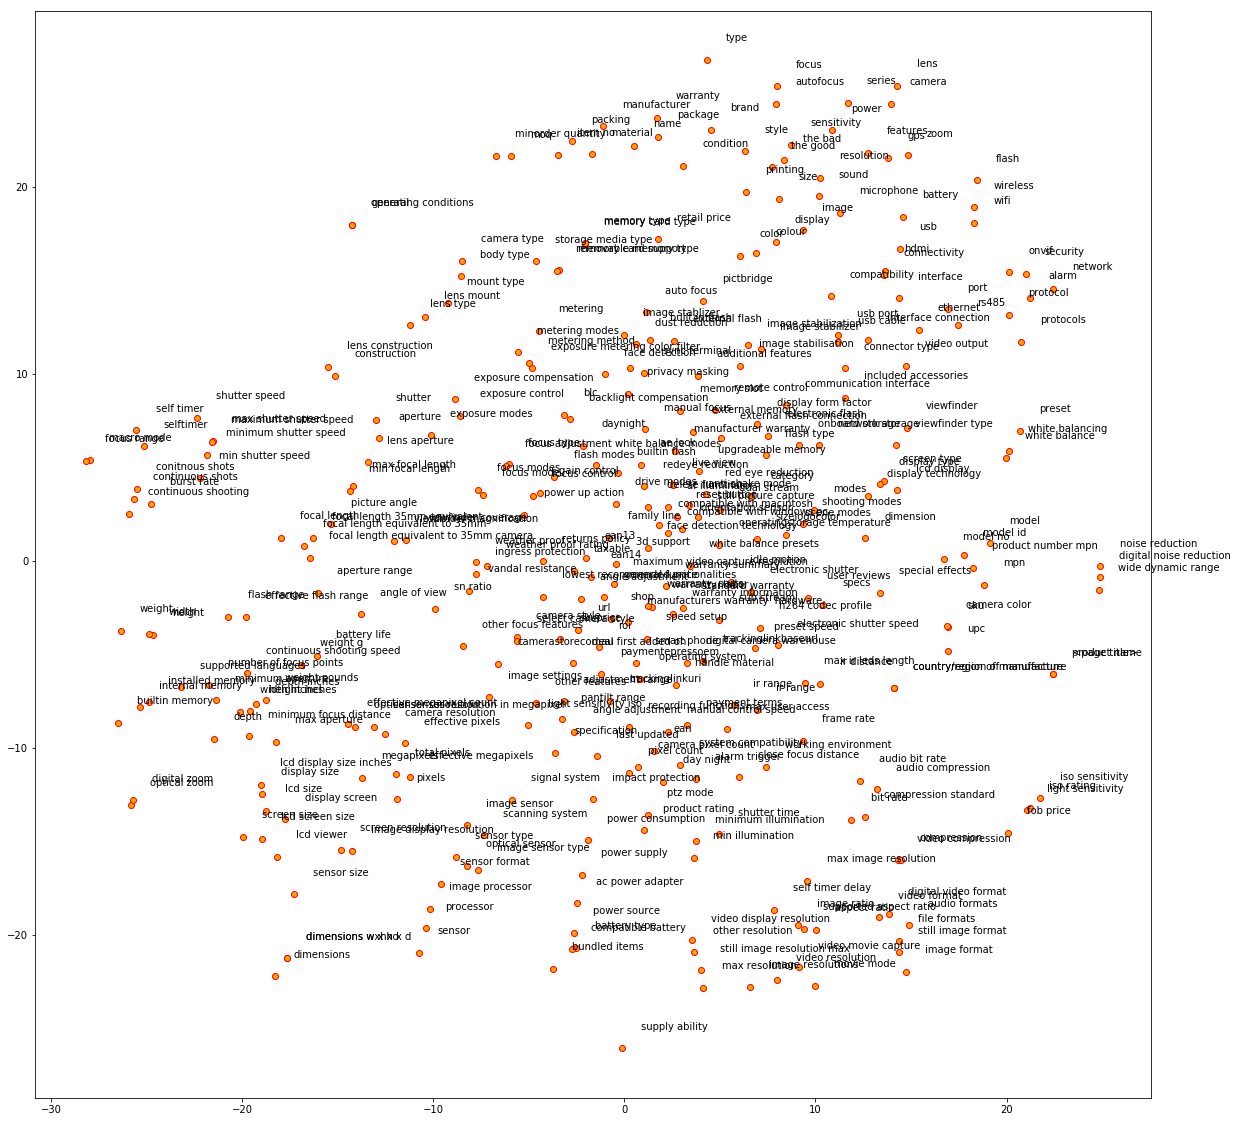

In [23]:
plt.show()

In [24]:
T.shape

(364, 2)

#### KMeans

In [25]:
from nltk.cluster import KMeansClusterer
import nltk
%matplotlib inline

In [26]:
NUM_CLUSTERS=50
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, avoid_empty_clusters=True,repeats=25)
assigned_clusters = kclusterer.cluster(T, assign_clusters=True)

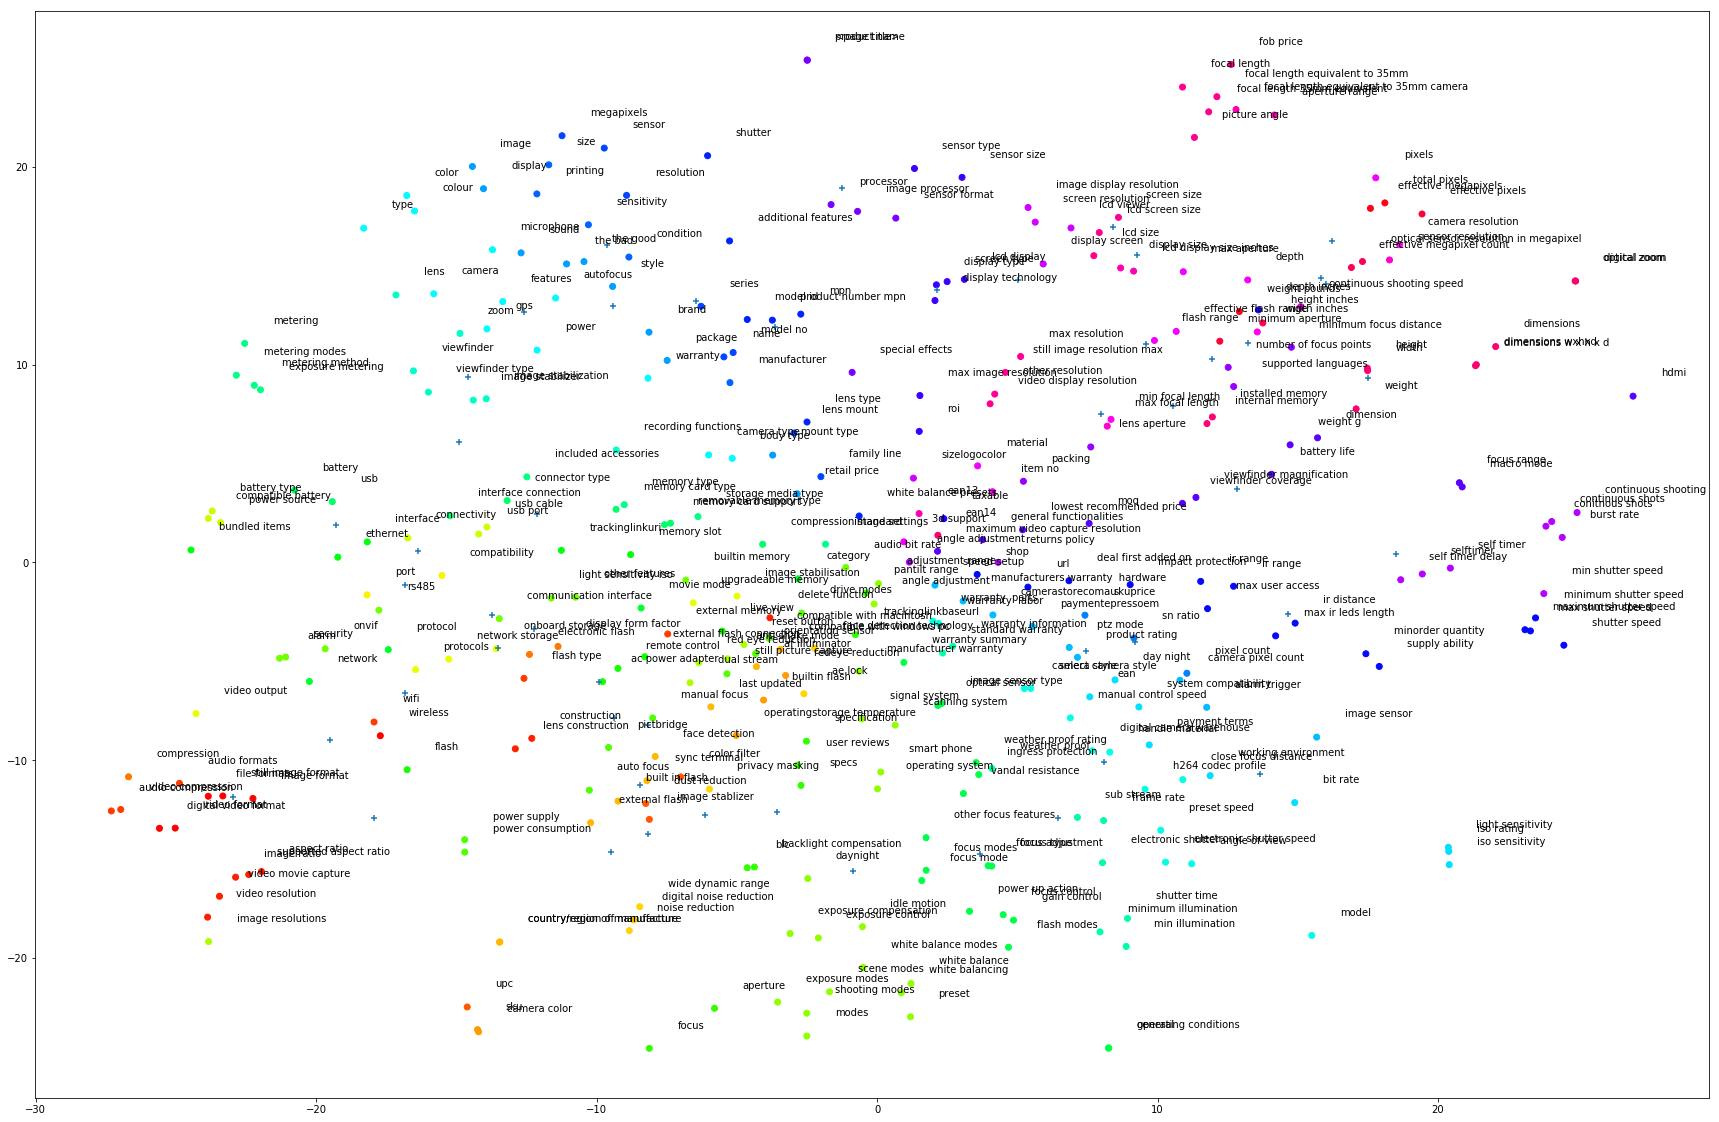

In [27]:
plt.figure(figsize=(30,20))
plt.scatter(T[:,0], T[:,1], c=assigned_clusters, cmap='hsv')
plt.scatter(np.array(kclusterer.means())[:,0], np.array(kclusterer.means())[:,1], marker='+', cmap='hsv')

for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [28]:
dataset_df,cluster2features = similar_feature_grouping.get_grouped_features(dataset_df,assigned_clusters,labels)

In [29]:
cluster2features

{0: ['image format',
  'digital video format',
  'video format',
  'still image format',
  'file formats',
  'wireless'],
 1: ['delete function',
  'supported aspect ratio',
  'aspect ratio',
  'video resolution',
  'video movie capture',
  'construction',
  'image ratio',
  'lens construction'],
 2: ['audio compression',
  'flash type',
  'wifi',
  'audio formats',
  'external memory',
  'video compression'],
 3: ['color filter', 'upc', 'image stablizer', 'dust reduction'],
 4: ['electronic flash', 'compression', 'display form factor'],
 5: ['sku',
  'camera color',
  'operatingstorage temperature',
  'builtin flash',
  'redeye reduction'],
 6: ['face detection',
  'last updated',
  'external flash',
  'af illuminator',
  'compatible with windows pc',
  'sync terminal',
  'built in flash',
  'country/region of manufacture',
  'countryregion of manufacture'],
 7: ['noise reduction',
  'digital noise reduction',
  'ae lock',
  'face detection technology',
  'privacy masking',
  'wide dy

In [31]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
dataset_df.loc[same_products[1]]

,source,spec_number,page_title,brand,blocking_key,all_features,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
spec_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
www.ebay.com//60035,www.ebay.com,60035,sony cyber shot 63x super zoom dsc h400 hd dig...,,[sony],"{'effective pixels': '20.1 megapixels', 'optic...",,,,027242877092,,,8 faces,,,,np-bx1 rechargeable li-ion battery,,yes,,,,built-in,hi-speed usb 2.0 usb multi audio/video,,,,,,optical steadyshot,,point & shoot,iso 80-3200,,,,"new: brand-new, unused, unopened, undamaged it...",20.1,4.4-277mm (24.5-1550mm equiv.),,,1/2.3 in. super ccd sensor,wide: 0.03 ft. (1cm) - infinity telephoto: 11....,sony cyber shot 63x super zoom dsc h400 hd dig...,,,,,,,f/3.4 - f/6.5,5152 x 3864 (20mp),60x brand: sony 63x 22.2 oz. (628g) 5.1 x 3.7 ...,,20.1 megapixels,20.4 megapixels
www.ebay.com//58266,www.ebay.com,58266,sony cyber shot dsc h400 20 1 mp 63x with soft...,Sony,[sony],"{'model': 'dsc-h400', 'brand': 'sony', 'megapi...",,,,,,,,,,,,,,,,,,case bag,,,,,,,dsc-h400,point & shoot,,,sony,,,20.1,,,,,,sony cyber shot dsc h400 20 1 mp 63x soft case...,,,,,,,,,63x,,,
www.wexphotographic.com//587,www.wexphotographic.com,587,sony cyber-shot h400 digital camera (dsch400b....,,[sony],"{'weight g': '655', 'colour': 'black', 'exposu...",jpeg,,built-in,,,,,,,,"multi (av/usb), hi-speed usb (usb2.0)",,+/- 2.0 ev (1/3 ev steps),,,,,,720p,,,,,,,black,,,,,129.6 x 95.0 x 122.3 mm,20.1 5152 x 3864,,,,cmos 1/2.3 inch,655,sony cyber-shot h400 digital camera (dsch400b....,,,,,,,,,,,,
www.ebay.com//55979,www.ebay.com,55979,sony cyber shot 63x super zoom dsc h400 hd dig...,,[sony],"{'effective pixels': '20.1 megapixels', 'iso s...",,,,,,,8 faces,,,,np-bx1 rechargeable li-ion battery,,yes,,,,built-in,hi-speed usb 2.0 usb multi audio/video case ba...,,,,,,optical steadyshot,,point & shoot,iso 80-3200,,,,"new: brand-new, unused, unopened, undamaged it...",20.1,4.4-277mm (24.5-1550mm equiv.),,,1/2.3 in. super ccd sensor,wide: 0.03 ft. (1cm) - infinity telephoto: 11....,sony cyber shot 63x super zoom dsc h400 hd dig...,,,,,,,f/3.4 - f/6.5,5152 x 3864 (20mp),22.2 oz. (628g) 63 brand: sony 63x 5.1 x 3.7 x...,,20.1 megapixels,20.4 megapixels


In [36]:
#concatanate new features
block_df['concat_text']=''
for i in range(NUM_CLUSTERS):
    block_df['concat_text']+=block_df[i]+' '
block_df['concat_text'] = block_df['concat_text'].apply(lambda x: x.replace('  ',' '))

/Users/gunesyurdakul/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/gunesyurdakul/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/gunesyurdakul/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

*****

## EXTRACTING SIMILARITY IN COLUMN not used for now

In [52]:
global counter
counter=0
block_df['page_title_sim']=""

/Users/gunesyurdakul/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [53]:
import re
from nltk import everygrams

block_df['concat_wordvector']=''
for index, row in block_df.iterrows():
    x=row['page_title']
    block_df.at[index,'concat_wordvector']=sigmod.get_avg_vector(\
        ' '.join([' '.join(x[idx:].split()[:3]) for idx in [x.start() for x in re.finditer(blocking_key, x)]] + [' '.join(sigmod.extract_model_words(token)) for token in list(everygrams(x.split(),2,3))]),blocking_key)                                                                                                                                                     

In [53]:
def get_sim_among_col(x,column_data):
    sim_array=np.zeros(len(column_data))
    i=0
    global counter
    for cell_data in column_data.values:
        sim_array[i]=helper.cosine_sim(helper.text_to_ngrams(x,3,'chars'),helper.text_to_ngrams(cell_data,3,'chars'))
        i+=1
    counter+=1
    if(counter%10==0):
        print(counter/len(column_data),np.mean(sim_array))
    return sim_array

In [54]:
block_df['page_title']=block_df['page_title'].apply(lambda x: x.replace(blocking_key,''))
block_df['page_title_sim']=block_df['page_title'].apply(lambda x: get_sim_among_col(x,block_df['page_title']))

/Users/gunesyurdakul/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


0.0035014005602240898 0.19126648424577478
0.0070028011204481795 0.1689694950953311
0.01050420168067227 0.14887461632559199


KeyboardInterrupt: 